In [0]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

In [0]:
#
# load data
#
df = pd.read_csv('synth_temp.csv')

In [0]:
#
# slice 1902 and forward
#
print(df.head())
df = df.loc[df.Year > 1901]
print(df.head)

  Region  Year  RgnAvTemp
0      A  1841  12.294252
1      B  1841  14.000614
2      E  1841  11.398660
3      F  1841  13.189420
4      A  1842  11.690257
<bound method NDFrame.head of      Region  Year  RgnAvTemp
292       A  1902  16.932383
293       B  1902  18.294661
294       C  1902  17.522463
295       D  1902  18.353418
296       E  1902  15.669523
...     ...   ...        ...
1619      H  2010  11.784998
1620      I  2010  22.574168
1621      J  2010  16.908291
1622      K  2010  19.780529
1623      L  2010  19.921533

[1332 rows x 3 columns]>


In [0]:
#
# roll up by year
#
df_group_year = df.groupby(['Year', 'Region']).agg({'RgnAvTemp':'mean'})
#
# note that the .droplevel() method removes the multiindex 
# added by the .agg() method() to make things simpler
# later on in our analysis
#
print(df_group_year.head(12))
print(df_group_year.tail(12))

             RgnAvTemp
Year Region           
1902 A       16.932383
     B       18.294661
     C       17.522463
     D       18.353418
     E       15.669523
     F       17.438122
     G       19.666101
     H       10.497845
     I       19.979361
     J       16.341659
     K       15.952242
     L       17.443564
             RgnAvTemp
Year Region           
2010 A       18.933159
     B       21.117157
     C       20.140428
     D       20.784400
     E       19.516141
     F       19.903760
     G       23.313424
     H       11.784998
     I       22.574168
     J       16.908291
     K       19.780529
     L       19.921533


In [0]:
#
# add the Year column so we can use that in a model
#
df_group_year['Year'] = df_group_year.index.get_level_values(0)
#
# add the region column so we can use that for dummy variables
#
df_group_year['Region'] = df_group_year.index.get_level_values(1)
#
# reset the index on the long axis
#
df_group_year = df_group_year.droplevel(0, axis = 0)
df_group_year = df_group_year.reset_index(drop = True)

In [0]:
#
# convert the categorial variable 'region' to dummy vars
#
dummy_cols = pd.get_dummies(df_group_year.Region)
df_group_year = pd.concat([df_group_year, dummy_cols], 
                          axis = 1).drop('Region', axis = 1)
print(df_group_year.head())
print(df_group_year.tail())

   RgnAvTemp  Year  A  B  C  D  E  F  G  H  I  J  K  L
0  16.932383  1902  1  0  0  0  0  0  0  0  0  0  0  0
1  18.294661  1902  0  1  0  0  0  0  0  0  0  0  0  0
2  17.522463  1902  0  0  1  0  0  0  0  0  0  0  0  0
3  18.353418  1902  0  0  0  1  0  0  0  0  0  0  0  0
4  15.669523  1902  0  0  0  0  1  0  0  0  0  0  0  0
      RgnAvTemp  Year  A  B  C  D  E  F  G  H  I  J  K  L
1303  11.784998  2010  0  0  0  0  0  0  0  1  0  0  0  0
1304  22.574168  2010  0  0  0  0  0  0  0  0  1  0  0  0
1305  16.908291  2010  0  0  0  0  0  0  0  0  0  1  0  0
1306  19.780529  2010  0  0  0  0  0  0  0  0  0  0  1  0
1307  19.921533  2010  0  0  0  0  0  0  0  0  0  0  0  1


In [0]:
linear_model = LinearRegression(fit_intercept = True)
linear_model.fit(df_group_year.loc[:, 'Year':'L'],
                 df_group_year.RgnAvTemp)
r2 = linear_model.score(df_group_year.loc[:, 'Year':'L'],
                 df_group_year.RgnAvTemp)
print('r squared ', r2)

r squared  0.7616922090074043


In [0]:
#
# construct data to predict from model
#
pred_X = df_group_year.drop('RgnAvTemp', axis = 1)
pred_Y = linear_model.predict(pred_X.values)
preds = pd.concat([pd.Series(pred_X.Year),  pd.Series(pred_Y)], axis = 1)
preds = preds.groupby('Year').agg('mean')
preds.columns = ['AvTemp']

In [0]:
preds

,AvTemp
Year,
1902,16.775808
1903,16.799722
1904,16.823635
1905,16.847548
1906,16.871461
...,...
2006,19.262782
2007,19.286695
2008,19.310609


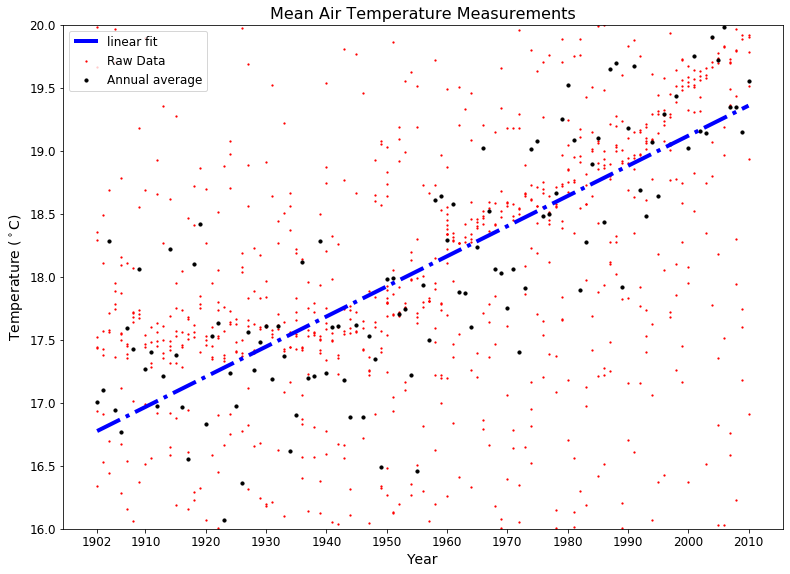

In [0]:
fig = plt.figure(figsize=(10, 7))
ax = fig.add_axes([1, 1, 1, 1]);
#
# Raw data
#
raw_plot_data = df[df.Year > 1901]
ax.scatter(raw_plot_data.Year, 
           raw_plot_data.RgnAvTemp, 
           label = 'Raw Data', 
           c = 'red', 
           s = 1.5)
#
# Annual averages
#
annual_plot_data = df_group_year.groupby('Year').agg('mean')
ax.scatter(annual_plot_data.index, 
           annual_plot_data.RgnAvTemp, 
           label = 'Annual average', 
           c = 'k',
           s = 10)
#
# linear fit
#
ax.plot(preds.index,
           preds.AvTemp, 
           c = "blue",
           linestyle = '-.',
           linewidth = 4,
           label = 'linear fit')
#
ax.set_title('Mean Air Temperature Measurements',
             fontsize = 16)
#
# make the ticks include the first and last years
#
tick_years = [1902] + list(range(1910, 2011, 10))
ax.set_xlabel('Year', 
              fontsize = 14)
ax.set_ylabel('Temperature ($^\circ$C)', 
              fontsize = 14)
ax.set_ylim(16, 20)
ax.set_xticks(tick_years)
ax.tick_params(labelsize = 12)
ax.legend(fontsize = 12)